# Two methods of K Graph Coloring Problem 2024.07.16

This notebook contains two methods of solving the graph coloring problem. Each includes QUBO matrix generated and finial color-dictionary results, also has result verification at last.

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite
import time

### General and MIS related functions

In [3]:
# Function to generate and draw a graph
def generate_graph(num_nodes=3, num_edges=3, edges=None, random=False, highlight_edges=None):
    G = nx.Graph()
    if random:
        G = nx.gnm_random_graph(num_nodes, num_edges)
        edges = list(G.edges())
    else:
        if edges is None:
            raise ValueError("Edges must be provided if not generating a random graph")
        if min(min(edges)) == 1:
            edges = [(u - 1, v - 1) for u, v in edges]  # Convert 1-based to 0-based
        G.add_edges_from(edges)
        nodes = set()
        for edge in edges:
            nodes.update(edge)
        num_nodes = len(nodes)
    
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="grey")
    if highlight_edges:
        nx.draw_networkx_edges(G, pos, edgelist=highlight_edges, edge_color='red', width=2)
    plt.show()
    
    return G, num_nodes, edges



def gen_matrix_MIS(num_nodes, MIS_P, edges):
    matrix_MIS = np.zeros((num_nodes, num_nodes))
    np.fill_diagonal(matrix_MIS, -1)
    for edge in edges:
        i, j = edge
        matrix_MIS[i, j] = MIS_P / 2
        matrix_MIS[j, i] = MIS_P / 2
    return matrix_MIS

# Function to reencode graph after removing specified nodes
def reencode_graph_and_edges(graph, nodes_to_remove):
    new_graph = graph.copy()
    new_graph.remove_nodes_from(nodes_to_remove)
    remaining_nodes = sorted(new_graph.nodes())
    mapping = {old_label: new_label for new_label, old_label in enumerate(remaining_nodes)}
    reencoded_graph = nx.relabel_nodes(new_graph, mapping)
    updated_edges = [(mapping[u], mapping[v]) for u, v in new_graph.edges()]
    return reencoded_graph, updated_edges, mapping

# Get nodes to remove from MIS sample
def get_nodes_to_remove(node_dict):
    return {node for node, value in node_dict.items() if value == 1}

# Function to draw graph
def draw_graph(graph, title="Graph"):
    pos = nx.spring_layout(graph)
    plt.figure(figsize=(8, 6))
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
    plt.title(title)
    plt.show()


In [4]:
def MIS(graph, sampler="SimulatedAnnealingSampler", QUBO_panality=2):
    print("Using: ", sampler)
    k = 1 # number of colors been used
    total_qpu_time = 0 # sum of all qpu_access_time

    # Loop until the graph is reduced to a single node
    current_graph = graph
    orignal = current_graph.nodes

    nodes_to_remove_set = []
    mapping_set = []
    results_MIS_set = []

    start_t = time.time_ns() 
    if sampler == "QPU":
        qpu = DWaveSampler()
        
    while len(current_graph.nodes) > 1:
        k += 1
        num_nodes = len(current_graph.nodes)
        edges = list(current_graph.edges)
        matrix_MIS = gen_matrix_MIS(num_nodes, QUBO_panality, edges)

        if sampler == "ExactSolver":
            bqm_MIS = dimod.BinaryQuadraticModel.from_qubo(matrix_MIS, offset=QUBO_panality)
            solver = dimod.ExactSolver()
            results_MIS = solver.sample(bqm_MIS)
            sample_MIS = results_MIS.lowest().first.sample
            results_MIS_set.append(results_MIS)
        elif sampler == "SimulatedAnnealingSampler":    
            results_MIS = dimod.SimulatedAnnealingSampler().sample_qubo(matrix_MIS)
            sample_MIS = results_MIS.first.sample
            results_MIS_set.append(results_MIS)
        elif sampler == "QPU":
            qpu_sampler = EmbeddingComposite(qpu)
            results_MIS= qpu_sampler.sample_qubo(matrix_MIS,return_embedding=True,label=f"MIS_{len(orignal)}nodes{k}", num_reads = 500)
            total_qpu_time += results_MIS.info["timing"]['qpu_access_time']
            sample_MIS = results_MIS.lowest().first.sample
            results_MIS_set.append(results_MIS)

        nodes_to_remove = get_nodes_to_remove(sample_MIS)
        # print("MIS solution:", sample_MIS)
        nodes_to_remove_set.append(nodes_to_remove)
        print("MIS:", nodes_to_remove)
    
        reencoded_graph, updated_edges, mapping = reencode_graph_and_edges(current_graph, nodes_to_remove)
        mapping_set.append(mapping)
        current_graph = reencoded_graph
        # print("Reencode graph:", mapping)
        # draw_graph(current_graph, title="Current Graph")
        # draw_graph(reencoded_graph, title="Re-encoded Graph")
    time_ms = (time.time_ns() - start_t)/1000000
    total_qpu_time = total_qpu_time/1000
   
    print("k colors:", k)
    print("total_qpu_time(ms):", total_qpu_time)
    print("total_time(ms):", time_ms)  
    # print("nodes_to_remove_set:", nodes_to_remove_set)
    # print("mapping_set", mapping_set)

    return k, total_qpu_time, time_ms, nodes_to_remove_set, mapping_set, orignal, results_MIS_set

In [5]:
def get_color_dict(color_dict, nodes_to_remove_set, mapping_set, orignal):

    def apply_mapping(current_set, depth, current_depth=0):
        x = depth - current_depth
        if current_depth == depth:
            for node in current_set:
                if node in color_dict:
                    color_dict[node] = loop
        else:
            next_set = set()
            for key, value in mapping_set[x-1].items():
                if value in current_set:
                    next_set.add(key)
            apply_mapping(next_set, depth, current_depth + 1)

    loop = 0
    for depth in range(len(nodes_to_remove_set)+1):
        loop += 1
        if depth > len(nodes_to_remove_set)-1:
            apply_mapping(mapping_set[depth-1], depth-1)
        else:
            apply_mapping(nodes_to_remove_set[depth], depth)

    print("Color results:", color_dict)
    return color_dict

In [6]:
def valid_results(graph, coloring):
    is_valid = validate_graph_coloring(graph, coloring)
    print("Is coloring valid? -", is_valid)
    is_minimum_coloring(graph, coloring)

def validate_graph_coloring(graph, coloring):
    for u, v in graph.edges():
        if coloring[u] == coloring[v]:
            return False  
    return True 

def get_approx_chromatic_number(graph):
    coloring = nx.greedy_color(graph, strategy="largest_first")
    used_colors = set(coloring.values())
    return len(used_colors)

def is_minimum_coloring(graph, coloring):
    approx_chromatic_number = get_approx_chromatic_number(graph)
    used_colors = set(coloring.values())
    if len(used_colors) == approx_chromatic_number:
        print("Is the coloring using minimum number of colors? -", True)
    else:
        print("Is the coloring using minimum number of colors? -", False)
        print("Minimum number of colors:", approx_chromatic_number)


### Directly mapping graph problem into QUBO related functions

In [7]:
def node_color_to_index(node, color, k):
    index = (node) * k + (color - 1)
    return index

def create_Qmatrix(k, G, QUBO_panaliy):
    num_nodes = len(G.nodes)
    edges = list(G.edges)
    
    matrix_size = num_nodes * k
    Qmatrix = np.zeros((matrix_size, matrix_size))

    QUBO_panaliy = 4  # Penalty

    for i in range(num_nodes):
        submatrix = Qmatrix[i*k:(i+1)*k, i*k:(i+1)*k]
        for row in range(k):
            for col in range(k):
                if row == col:
                    submatrix[row, col] = -QUBO_panaliy
                else:
                    submatrix[row, col] = QUBO_panaliy
    for edge in edges:
        node1, node2 = edge
        for color in range(1, k + 1):
            index1 = node_color_to_index(node1, color, k)
            index2 = node_color_to_index(node2, color, k)
            Qmatrix[index1, index2] = QUBO_panaliy / 2
            Qmatrix[index2, index1] = QUBO_panaliy / 2

    return Qmatrix

In [8]:
def DirectlySolve(graph, sampler="SimulatedAnnealingSampler", k=3, QUBO_panality=4):
    print("Using: ", sampler)
    qpu_time = 0
    start_t = time.time_ns() 

    Qmatrix = create_Qmatrix(k, G, QUBO_panality)
    # print(Qmatrix)
    print("Shape of DirectlySolve Qmatrix:", Qmatrix.shape)

    if sampler == "ExactSolver":
        bqm = dimod.BinaryQuadraticModel.from_qubo(Qmatrix, offset=QUBO_panality)
        solver = dimod.ExactSolver()
        results = solver.sample(bqm)
        sample = results.lowest().first.sample
    elif sampler == "SimulatedAnnealingSampler":    
        results = dimod.SimulatedAnnealingSampler().sample_qubo(Qmatrix)
        sample = results.first.sample
    elif sampler == "QPU":
        qpu = DWaveSampler()
        qpu_sampler = EmbeddingComposite(qpu)
        results= qpu_sampler.sample_qubo(Qmatrix,return_embedding=True,label=f"DirectlySolve_{len(G.nodes)}nodes{k}colors", num_reads = 500)
        qpu_time = (results.info["timing"]['qpu_access_time'])/1000
        sample = results.lowest().first.sample

    time_ms = (time.time_ns() - start_t)/1000000
    print("Solution DirectlySolve:", sample)
    print("qpu_time_DirectlySolve(ms):", qpu_time)
    print("total_time_DirectlySolve(ms):", time_ms)

    return qpu_time, time_ms, sample, results


In [9]:
def solution_to_color_dict(solution, num_nodes, k=3):
    color_dict = {}
    for node in range(num_nodes):
        for color in range(k):
            if solution[node * k + color] == 1:
                color_dict[node] = color + 1
                break

    print("DirectlySolve_Color_Results:",color_dict)
    return color_dict

# Example

## 1. Generate graph problem

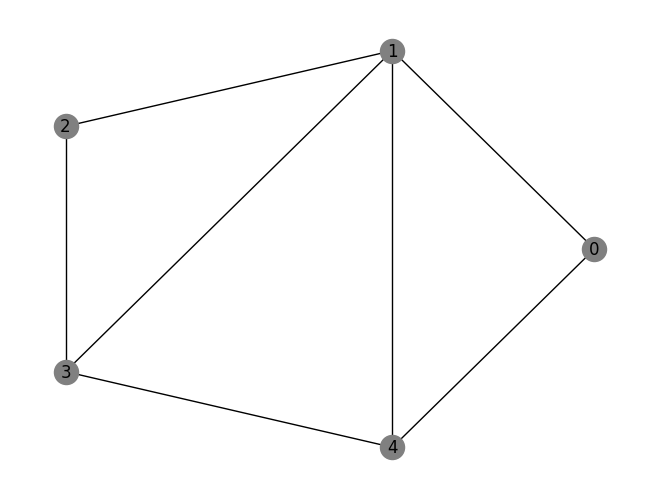

In [10]:
# Fixed Graph
example_edges = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 1), (5, 2), (2, 4)]
G, num_nodes, edges = generate_graph(edges=example_edges)

# Random Graph
# num_nodes = 100
# G, num_nodes, edges = generate_graph(num_nodes, num_nodes*4.5, random=True)

## 2. Using MIS method to solve the problem

In [11]:
k, total_qpu_time, time_ms, MIS_set, reencode_set, orignal_nodes, results_sets_MIS = MIS(G, sampler="QPU")
color_dict = {node: [] for node in orignal_nodes}
result = get_color_dict(color_dict, MIS_set, reencode_set, orignal_nodes)
valid_results(G, result)

Using:  QPU
MIS: {0, 2}
MIS: {0}
MIS: {0}
k colors: 4
total_qpu_time(ms): 177.99388000000002
total_time(ms): 9435.8569
Color results: {0: 1, 1: 2, 2: 1, 3: 3, 4: 4}
Is coloring valid? - True
Is the coloring using minimum number of colors? - False
Minimum number of colors: 3


## 3. Directly solve the problem 

In [12]:
qpu_time_DirectlySolve, time_ms_DirectlySolve, solution_found, result_DS = DirectlySolve(G, sampler="QPU")
k_preset = 3
result_DirectlySolve = solution_to_color_dict(solution_found, num_nodes, k_preset)
valid_results(G, result_DirectlySolve)

Using:  QPU
Shape of DirectlySolve Qmatrix: (15, 15)
Solution DirectlySolve: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1}
qpu_time_DirectlySolve(ms): 74.38756
total_time_DirectlySolve(ms): 4483.7686
DirectlySolve_Color_Results: {0: 1, 1: 2, 2: 3, 3: 1, 4: 3}
Is coloring valid? - True
Is the coloring using minimum number of colors? - True


## 4. Results comparision

In [13]:
result_DS.info

{'timing': {'qpu_sampling_time': 58630.0,
  'qpu_anneal_time_per_sample': 20.0,
  'qpu_readout_time_per_sample': 76.68,
  'qpu_access_time': 74387.56,
  'qpu_access_overhead_time': 1185.44,
  'qpu_programming_time': 15757.56,
  'qpu_delay_time_per_sample': 20.58,
  'post_processing_overhead_time': 1.0,
  'total_post_processing_time': 1.0},
 'problem_id': '24dc78d8-576d-4680-b67c-f88631117c5f',
 'problem_label': 'DirectlySolve_5nodes3colors',
 'embedding_context': {'embedding': {1: (572,),
   0: (3287, 557),
   2: (3407,),
   3: (3377,),
   4: (3303, 646),
   5: (677, 676),
   6: (616,),
   7: (601,),
   8: (3348,),
   9: (3362,),
   10: (3333, 631),
   11: (662,),
   12: (587,),
   13: (3318, 737),
   14: (3393, 3392)},
  'chain_break_method': 'majority_vote',
  'embedding_parameters': {},
  'chain_strength': 4.646878177873829}}

In [14]:
embedding_qubits = result_DS.info["embedding_context"]["embedding"]
qubits = set()
for q in embedding_qubits.values():
    qubits.update(q)

# print("Qubits embedding:", embedding_qubits)
print("Qubits set:", qubits)
print("Number of qubits:", len(qubits))

Qubits set: {3333, 646, 3348, 662, 3362, 676, 677, 557, 3377, 572, 3392, 3393, 587, 3407, 3287, 601, 737, 3303, 616, 3318, 631}
Number of qubits: 21


In [15]:
results_sets_MIS[0].info

{'timing': {'qpu_sampling_time': 39410.0,
  'qpu_anneal_time_per_sample': 20.0,
  'qpu_readout_time_per_sample': 38.24,
  'qpu_access_time': 55167.96,
  'qpu_access_overhead_time': 1409.04,
  'qpu_programming_time': 15757.96,
  'qpu_delay_time_per_sample': 20.58,
  'total_post_processing_time': 1.0,
  'post_processing_overhead_time': 1.0},
 'problem_id': 'db6d817b-2813-4e5e-b282-92832042e00c',
 'problem_label': 'MIS_5nodes2',
 'embedding_context': {'embedding': {1: (2660,),
   0: (4019,),
   2: (3913,),
   3: (2645,),
   4: (4004,)},
  'chain_break_method': 'majority_vote',
  'embedding_parameters': {},
  'chain_strength': 1.1830372775191829}}

In [16]:
embedding_qubits_First_MIS = results_sets_MIS[0].info["embedding_context"]["embedding"]
qubits_First_MIS = set()
for q in embedding_qubits_First_MIS.values():
    qubits_First_MIS.update(q)

# print("Qubits embedding of first MIS:", embedding_qubits)
print("Qubits set of first MIS:", qubits_First_MIS)
print("Number of qubits of first MIS:", len(qubits_First_MIS))

Qubits set of first MIS: {4004, 2660, 3913, 4019, 2645}
Number of qubits of first MIS: 5


In [17]:
results_sets_MIS[1].info

{'timing': {'qpu_sampling_time': 54110.0,
  'qpu_anneal_time_per_sample': 20.0,
  'qpu_readout_time_per_sample': 67.64,
  'qpu_access_time': 69867.96,
  'qpu_access_overhead_time': 551.04,
  'qpu_programming_time': 15757.96,
  'qpu_delay_time_per_sample': 20.58,
  'total_post_processing_time': 1.0,
  'post_processing_overhead_time': 1.0},
 'problem_id': 'b5bcd65e-666e-4da6-b280-e30fa528bfdc',
 'problem_label': 'MIS_5nodes3',
 'embedding_context': {'embedding': {1: (228,), 0: (213,), 2: (3615,)},
  'chain_break_method': 'majority_vote',
  'embedding_parameters': {},
  'chain_strength': 0.9998489885977783}}

In [18]:
embedding_qubits_First_MIS = results_sets_MIS[1].info["embedding_context"]["embedding"]
qubits_First_MIS = set()
for q in embedding_qubits_First_MIS.values():
    qubits_First_MIS.update(q)

# print("Qubits embedding of first MIS:", embedding_qubits)
print("Qubits set of first MIS:", qubits_First_MIS)
print("Number of qubits of first MIS:", len(qubits_First_MIS))

Qubits set of first MIS: {228, 213, 3615}
Number of qubits of first MIS: 3
